In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Custom libraries/methods
from libs import split_data, evaluate_model

In [3]:
# Load dataset
df = pd.read_csv("data/preprocessed/main_ML_ready.csv")
df.head()

,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Dept,Weekly_Sales,Store_Size,Year,Month,Day,Week,Store_Type_A,Store_Type_B,Store_Type_C
0,1,-0.963831,-1.72052,1.018422,0.078331,False,1,24924.50,0.238802,2010,2,5,5,True,False,False
1,1,-0.963831,-1.72052,1.018422,0.078331,False,2,50605.27,0.238802,2010,2,5,5,True,False,False
2,1,-0.963831,-1.72052,1.018422,0.078331,False,3,13740.12,0.238802,2010,2,5,5,True,False,False
3,1,-0.963831,-1.72052,1.018422,0.078331,False,4,39954.04,0.238802,2010,2,5,5,True,False,False
4,1,-0.963831,-1.72052,1.018422,0.078331,False,5,32229.38,0.238802,2010,2,5,5,True,False,False


### Split Data

In [4]:
# Split the data
X_train, X_test, y_train, y_test = split_data(df, target_column="Weekly_Sales")
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (336169, 15)
y_train shape:  (336169,)
X_test shape:  (84043, 15)
y_test shape:  (84043,)


# Random Forest

### Train Random Forest Base Model

In [4]:
# Initialize the model
rf = RandomForestRegressor(random_state=42, n_estimators=50)

# Train the model
rf.fit(X_train, y_train)

# Predict on the Test set
y_pred_rf = rf.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest MAE: {mae_rf}")

# Training Accuracy
acc_rf= round(rf.score(X_train, y_train) * 100, 3)
print (f"Training Accuracy: {acc_rf} %")

KeyboardInterrupt: 

### Hyperparameter Tuning using Grid search + Cross validation

In [18]:
# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error', # Set scoring to MAE
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=2  # Verbosity for monitoring progress
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

# Get the best model
best_rf_model = grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: -1414.7980392785128


### Evaluate test data on tuned model

In [7]:
# Training Model with Hyperparameter Tuning
best_rf_model = RandomForestRegressor(random_state=42, n_estimators=200, min_samples_split=2)
best_rf_model.fit(X_train, y_train)

# Training Accuracy with Hyperparameter Tuning
final_predictions = best_rf_model.predict(X_test)
print(evaluate_model(y_test, final_predictions))

Mean Absolute Error (MAE): 1290.62
Root Mean Squared Error (RMSE): 3195.26
R² Score: 0.98
None


### Feature Importance for Random Forest

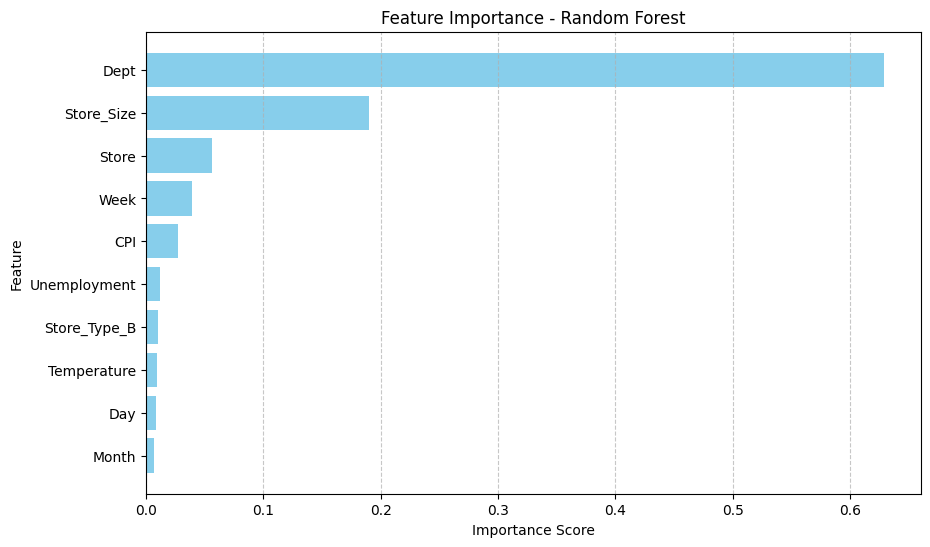

Top 10 Features by Importance:
         Feature  Importance
6           Dept    0.628948
7     Store_Size    0.190512
0          Store    0.055963
11          Week    0.039441
3            CPI    0.027335
4   Unemployment    0.011608
13  Store_Type_B    0.010644
1    Temperature    0.009739
10           Day    0.008989
9          Month    0.007139


In [9]:
# Feature Importance for Random Forest
importances = best_rf_model.feature_importances_

# Extract feature importances from the best Random Forest model
feature_importances = best_rf_model.feature_importances_
features = X_train.columns  # Feature names

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df.head(10)['Feature'], importance_df.head(10)['Importance'], color='skyblue')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Display the top features
print("Top 10 Features by Importance:")
print(importance_df.head(10))


### Residual Analysis

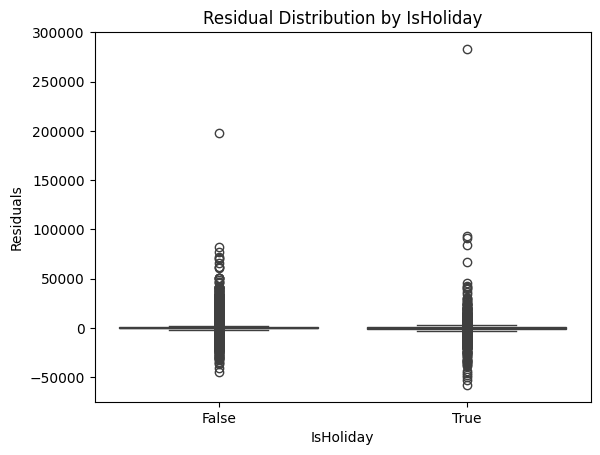

In [10]:
# Calculate residuals
residuals = y_test - best_rf_model.predict(X_test)

# Add residuals to a DataFrame
residuals_df = pd.DataFrame({'Residuals': residuals, 'IsHoliday': df['IsHoliday']})

# Plot residual distribution by group
import seaborn as sns
sns.boxplot(x='IsHoliday', y='Residuals', data=residuals_df)
plt.title('Residual Distribution by IsHoliday')
plt.show()